In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 메모리 제한 설정 (필요에 따라 수정 가능)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
        )
        print("GPU 설정 완료")
    except RuntimeError as e:
        print(e)

GPU 설정 완료


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# 경로 설정
train_dir = "../../Dataset_4_class/Train"
test_dir = "../../Dataset_4_class/Test"

# 데이터셋 로드 및 전처리
datagen = ImageDataGenerator(rescale=1./255)  # 이미지 정규화

train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # EfficientNetB0의 입력 크기
    batch_size=8,
    class_mode='categorical'  # 다중 클래스 분류 문제
)

test_dataset = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # EfficientNetB0의 입력 크기
    batch_size=8,
    class_mode='categorical'
)

# EfficientNetB0 모델 구성
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False  # 사전 학습된 가중치는 동결

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_dataset.num_classes, activation='softmax')  # 클래스 수에 맞게 출력
])

# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # 다중 클래스 분류의 경우 'categorical_crossentropy'
    metrics=['accuracy']
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='loss',  # 검증 데이터 없이 'loss'로 모니터링
    patience=3,
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

# 모델 평가 (테스트 데이터셋 사용)
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 모델 저장
model.save('EfficientNetB0.h5')


Found 31102 images belonging to 4 classes.
Found 7686 images belonging to 4 classes.
Epoch 1/10
3888/3888 [==============================] - 69s 17ms/step - loss: 1.3867 - accuracy: 0.2563 - val_loss: 1.3580 - val_accuracy: 0.6224
Epoch 2/10
3888/3888 [==============================] - 70s 18ms/step - loss: 1.3853 - accuracy: 0.2546 - val_loss: 1.3643 - val_accuracy: 0.1023
Epoch 3/10
3888/3888 [==============================] - 65s 17ms/step - loss: 1.3852 - accuracy: 0.2569 - val_loss: 1.3683 - val_accuracy: 0.1023
Epoch 4/10
3888/3888 [==============================] - 62s 16ms/step - loss: 1.3853 - accuracy: 0.2551 - val_loss: 1.3611 - val_accuracy: 0.1023
Epoch 5/10
3888/3888 [==============================] - 66s 17ms/step - loss: 1.3852 - accuracy: 0.2531 - val_loss: 1.3650 - val_accuracy: 0.1023
Epoch 6/10
3888/3888 [==============================] - 64s 16ms/step - loss: 1.3852 - accuracy: 0.2563 - val_loss: 1.3469 - val_accuracy: 0.6224
Epoch 7/10
3888/3888 [=================

/home/lakimas/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


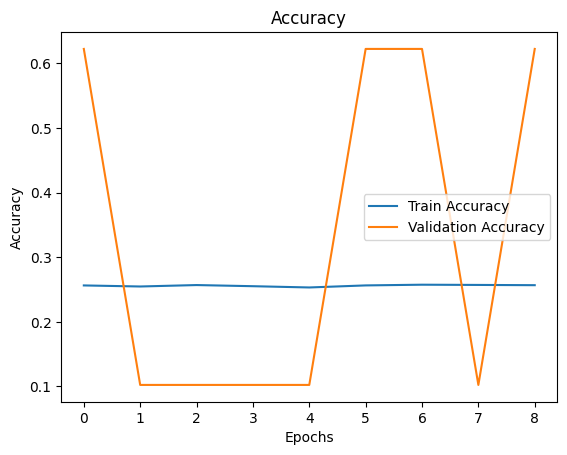

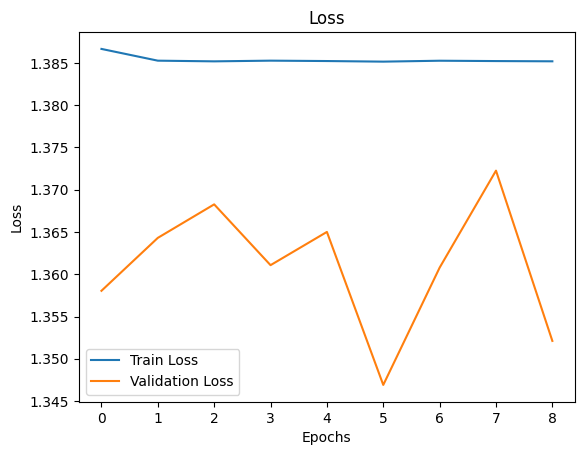

In [5]:
import matplotlib.pyplot as plt
print(history.history.keys())

# 학습 및 검증 정확도 그래프
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("1")
plt.show()

# 학습 및 검증 손실 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("2")
plt.show()

1/1 [==============================] - 0s 22ms/step
Custom font not found. Using default font.


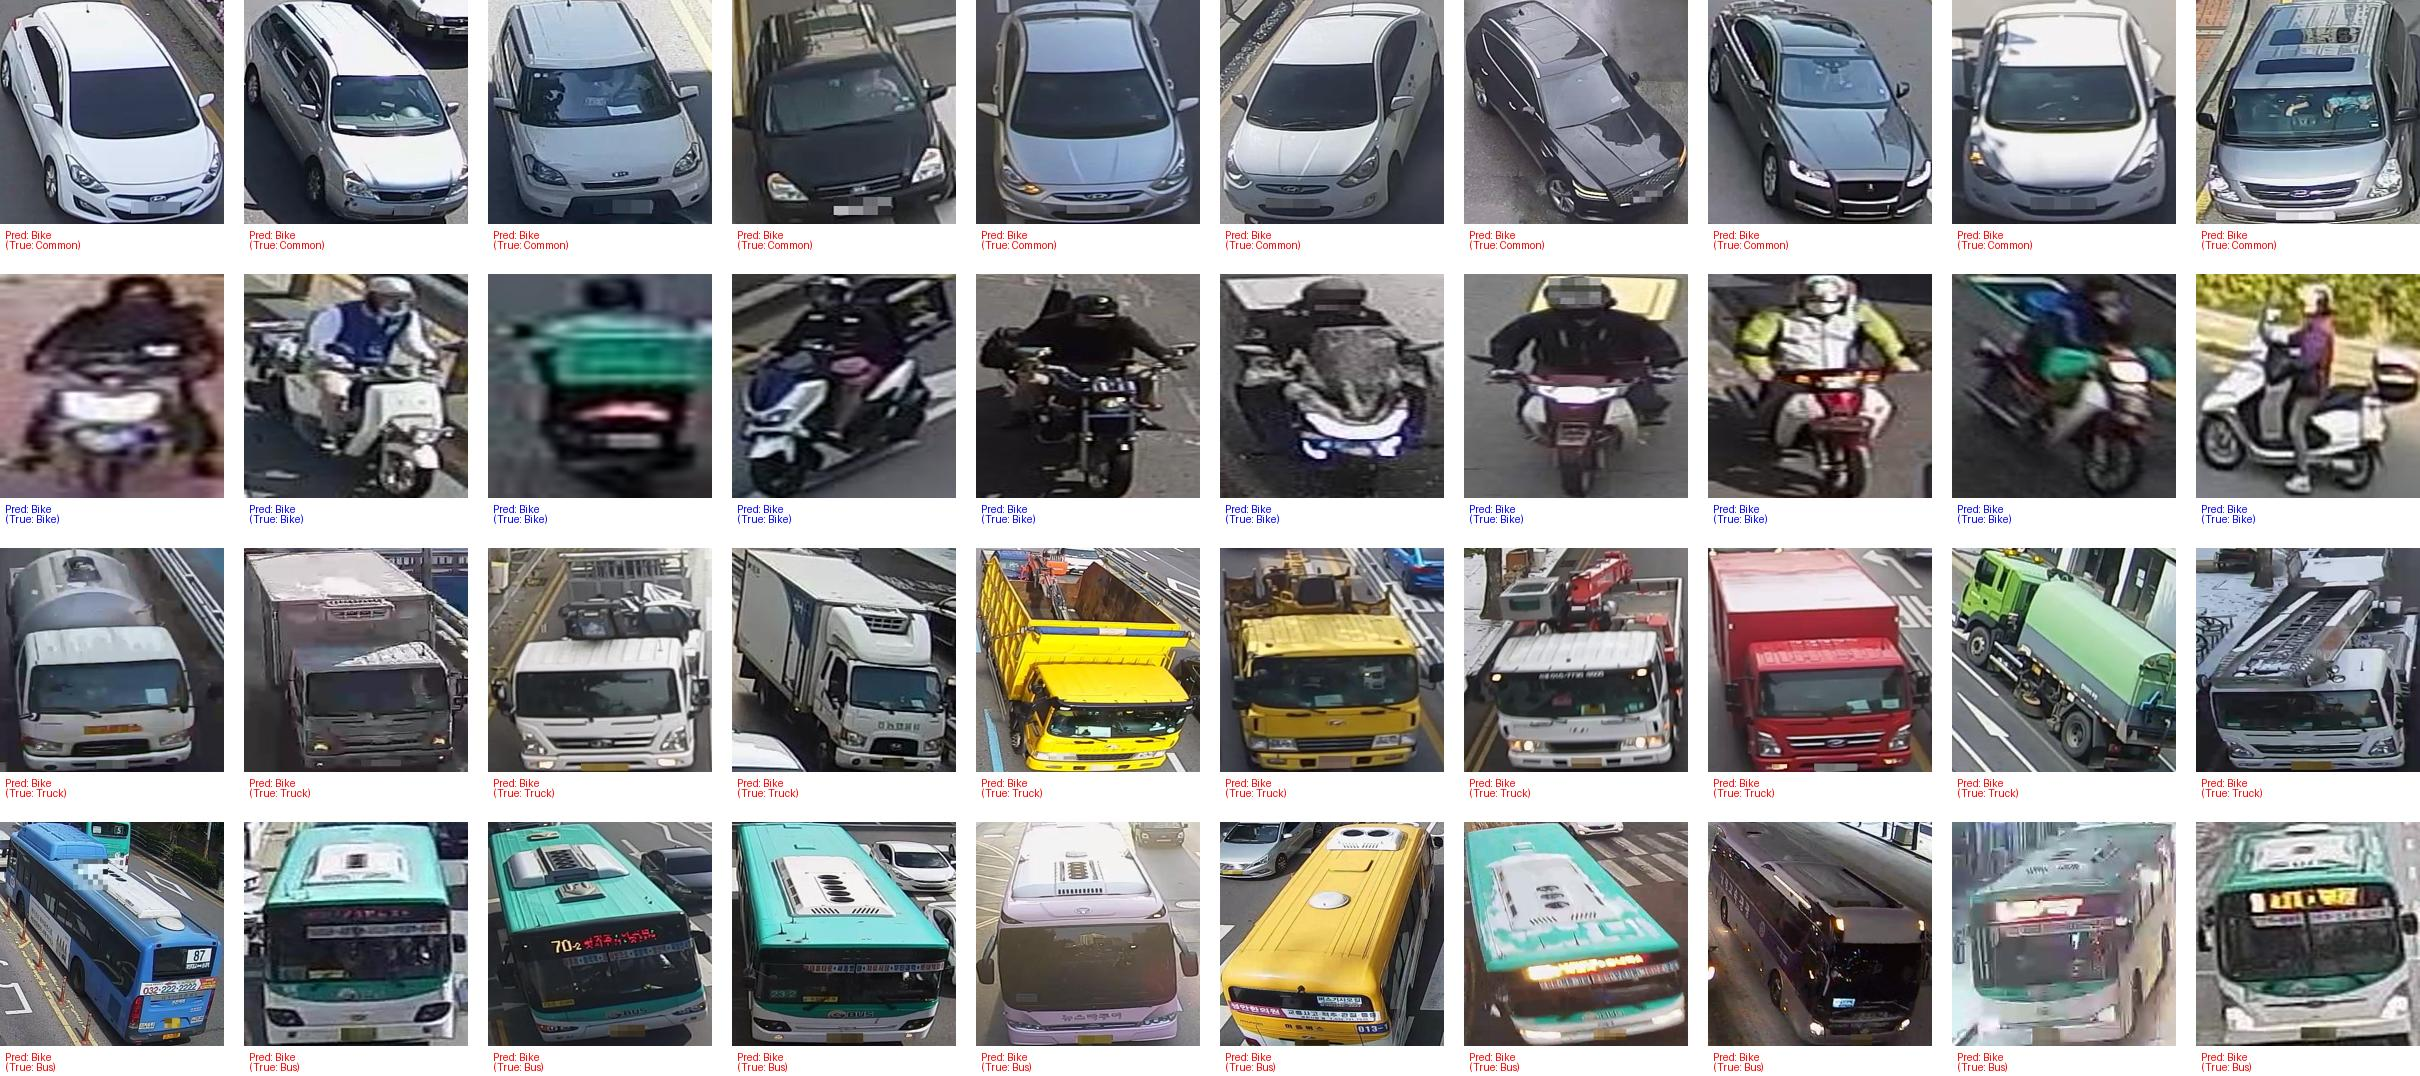

In [7]:
import os
import random
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np

# 모델 로드
model = load_model('EfficientNetB0.h5')  # 저장된 EfficientNetB0 모델

# 데이터 경로와 클래스 설정
test_dir = '../../Dataset_4_class/Test'

# 클래스 이름을 가져오기 (훈련 데이터 디렉토리에서 가져옴)
train_dir = '../../Dataset_4_class/Train'  # 학습 데이터 경로 (클래스 폴더 이름이 필요함)
index_to_class = [folder for folder in os.listdir(train_dir)
                  if os.path.isdir(os.path.join(train_dir, folder)) and folder != '.ipynb_checkpoints']

# 모델 입력 크기
img_size = (224, 224)  # EfficientNetB0의 입력 크기

# 여백 설정
padding = 20  # 이미지 간 여백 (픽셀 단위)
text_height = 30  # 텍스트 영역 높이

# 랜덤 샘플 테스트
results = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_path):  # 디렉토리인지 확인
        continue

    # 해당 클래스 폴더의 모든 파일 가져오기
    images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    # 랜덤으로 10개 선택 (이미지가 10개 미만이면 모두 선택)
    sampled_images = random.sample(images, min(10, len(images)))

    # 예측 수행
    for image_path in sampled_images:
        # 이미지 로드 및 전처리
        img = load_img(image_path, target_size=img_size, color_mode='rgb')
        img_array = img_to_array(img) / 255.0  # EfficientNetB0는 0-1 범위로 정규화
        img_array = np.expand_dims(img_array, axis=0)

        # 예측
        predictions = model.predict(img_array)
        predicted_index = np.argmax(predictions, axis=1)[0]
        predicted_class = index_to_class[predicted_index]

        # 결과 저장
        results.append({
            'image': image_path,
            'predicted_class': predicted_class,
            'true_class': class_name
        })

# 이미지 합치기
num_images_per_row = 10  # 가로에 표시할 이미지 수
output_width = img_size[0] * num_images_per_row + padding * (num_images_per_row - 1)  # 가로 크기
num_rows = (len(results) + num_images_per_row - 1) // num_images_per_row  # 전체 행 수
output_height = (img_size[1] + text_height) * num_rows + padding * (num_rows - 1)  # 세로 크기
output_image = Image.new("RGB", (output_width, output_height), "white")

# 폰트 설정 (기본 폰트 사용)
try:
    font_path = "C:/Windows/Fonts/arial.ttf"  # Windows 시스템 기본 폰트 경로
    font = ImageFont.truetype(font_path, size=12)
except OSError:
    print("Custom font not found. Using default font.")
    font = ImageFont.load_default()

draw = ImageDraw.Draw(output_image)

# 각 이미지를 합친다
x_offset, y_offset = 0, 0
for i, result in enumerate(results):
    # 이미지 열기
    img = Image.open(result['image']).resize(img_size)
    output_image.paste(img, (x_offset, y_offset))

    # 예측 텍스트 추가 (이미지 아래, 개행 포함)
    text = f"Pred: {result['predicted_class']}\n(True: {result['true_class']})"
    text_color = "blue" if result['predicted_class'] == result['true_class'] else "red"  # 색상 결정

    # 여러 줄 텍스트 작성
    text_x = x_offset + 5
    text_y = y_offset + img_size[1] + 5  # 이미지 바로 아래
    for line in text.split("\n"):  # 개행 기준으로 나누어 작성
        draw.text((text_x, text_y), line, fill=text_color, font=font)
        text_y += 10  # 줄 간격 추가 (폰트 크기 고려)

    # 다음 위치로 이동
    x_offset += img_size[0] + padding
    if x_offset >= output_width:  # 한 줄이 가득 찼을 경우
        x_offset = 0
        y_offset += img_size[1] + text_height + padding

# 결과 이미지 저장
output_image_path = "EfficientNetB0_combined_predictions_colored_text.jpg"
output_image.save(output_image_path)

# 이미지 출력 (Jupyter Notebook에서)
output_image = Image.open(output_image_path)
display(output_image)
